# Rate of Warming of Global Countries and Cities
## *Analysis of rate of warming across Earth (1880-2013)*
**** 

![SegmentLocal](warmingearth.gif "segment")

Source: https://climate.nasa.gov/

<a id='TOC'></a>
1. [Introduction](#Introduction)
2. [Data Overview](#Overview)<br>
    a. [Loading](#Loading)<br>
    b. [Cleaning/Filtering](#Cleaning)<br>
3. [Exploratory Data Analysis (EDA)](#EDA)<br>
    a. [Warmest & coldest countries/cities](#Extremes)<br> 
    b. [Average global temperature over time](#Trending)<br>
4. [Answering Questions](#Answers)<br>
    a. [Fastest-Warming Countries & Cities and Temperature Ranges](#Fastest)<br>  
5. [Conclusions, Recommendations, and Areas for Further Exploration](#Conclusion)

**** 
<a id='Introduction'></a>
### 1. [Introduction](#Introduction)

In this analysis, we will look at average temperature readings for several countries and cities across the globe in order to determine:
* the warmest and coldest countries,
* the warmest and coldest cities,
* the country and city with the greatest rate of warming\*,
* the country and city with the greatest ranges in average temperatures.

\* Note: "*greatest rate of warming*" will be defined as the location that has the greatest rolling 10-year average increase in average temperature change. This calculated field is not included in the raw data, so it will be added as a column in our working dataframes.

The purpose of this analysis is to inform global citizens of the urgency with which to act as our planet continues to warm. Of course, those based in any of the countries or cities that are found to be warming at an increased rate will immediately see the relevancy in their own lives but this information should also be taken into consideration by individuals that live elsewhere in the world, at the very least for the sake of empathy and empowerment.

#### Hypothesis
Broadly speaking, our hypothesis is that the coldest countries and cities will be situated closer to the North/South poles, whereas the warmest countries and cities will be situated closer to the equator. Additionally, we hypothesize that the countries and cities with the greatest rate of warming will be closer to the poles, as a result of the albedo effect (i.e., the loss of snow and sea ice resulting in less sunlight being reflected) and the related change in weather systems, as a result. 

[Back to TOC](#TOC)

**** 
<a id='Overview'></a>
### 2. [Data Overview](#Overview)

This analysis will work with two datasets:
* `GlobalLandTemperaturesByCountry.csv` and
* `GlobalLandTemperaturesByCity.csv`

We will first use the `GlobalLandTemperaturesByCountry.csv` set in order to look at warming on a national scale, followed by an identical analysis with the `GlobalTemperaturesByCity.csv` set to observe warming across global cities.

Ideally, we are able to answer such questions as:
* *Which country/countries is/are warming the fastest?*
* *Which city/cities is/are warming the fastest?*
* *Can we accurately predict temperatures for a specific country or city?*

It should be noted that although both datasets contain average temperatures (at the country or city level respectively) dating back to 1743(!), we will only be using records from 1880 onward for the sake of volume processing.

<a id='Loading'></a>
#### [Loading the Data](#Loading)

In [1]:
# data analysis
import numpy as np 
import pandas as pd 

# dataviz
import matplotlib
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns

# forecasting tools
import itertools
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# other misc. libraries
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'b'

colors = ['xkcd:grey', 'xkcd:light purple', 'xkcd:light yellow','xkcd:light green']

In [3]:
# load Country csv
country=pd.read_csv('GlobalLandTemperaturesByCountry.csv',
                 infer_datetime_format=True,
                date_parser=True)

country['dt']=pd.to_datetime(country['dt'])


# load City csv
city=pd.read_csv('GlobalLandTemperaturesByCity.csv',
                 infer_datetime_format=True,
                date_parser=True)

city['dt']=pd.to_datetime(city['dt'])

[Back to TOC](#TOC)

<a id='Cleaning'></a>
#### [Cleaning/Filtering](#Cleaning)

We will first work with the `Country` data. Let's take surface look at the table and the number of rows (i.e., `shape[0]`).

In [4]:
country.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland


In [5]:
country.shape[0]

577462

In [6]:
# data types
country.dtypes

dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
Country                                  object
dtype: object

In this table, we have the following columns:
* `dt` (datetime): date (YYYY-MM-DD), observations collected monthly from 1743-11-01 through 2013-09-01
* `AverageTemperature` (float): average temperature, recorded in degrees Celsius (°C)
* `AverageTemperatureUncertainty` (float): the 95% confidence interval around the average
* `Country` (object, string): ... the country

At an initial glance, with over half of a million records, we will begin by cleaning the `country` table to see how many NaN values exist and where in the table they fall.

In [7]:
country.isna().sum()

dt                                   0
AverageTemperature               32651
AverageTemperatureUncertainty    31912
Country                              0
dtype: int64

We have 32,641 temperature points missing out of 577,462 (~5.5%). We will filter the dataset to include only records from 1880 onward and reassess.

In [8]:
# filtered (1880 onwards)
country_filt=country[(country['dt']>'1879-12-31')]
country_filt.shape[0]

386654

In [9]:
country_filt.isna().sum()

dt                                  0
AverageTemperature               2658
AverageTemperatureUncertainty    1919
Country                             0
dtype: int64

After filtering by date, we now have 2658 missing temperature records out of 386, 654 in total (< 1%).

With this, we can more confidently drop the NaN values that remain.

In [10]:
# drop NaNs inplace
country_filt.dropna(how='any',axis=0, inplace=True)

# confirm
country_filt.isna().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
Country                          0
dtype: int64

In [11]:
# the head of the working table
country_filt.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
1634,1880-01-01,-1.928,1.186,Åland
1635,1880-02-01,-0.920,0.927,Åland
1636,1880-03-01,-0.838,0.671,Åland
1637,1880-04-01,2.111,0.514,Åland
1638,1880-05-01,6.393,0.727,Åland


In [12]:
# total remaining records
country_filt.shape[0]

383996

We will now take a look at the number of distinct `Country` entries in this table, primarily to ensure there are no duplicates but also to get a sense of how global this dataset really is.

In [13]:
# unique countries in dataset, sorted
unique_countries=pd.unique(country_filt['Country'])
unique_countries.sort()
print(unique_countries)

['Afghanistan' 'Africa' 'Albania' 'Algeria' 'American Samoa' 'Andorra'
 'Angola' 'Anguilla' 'Antigua And Barbuda' 'Argentina' 'Armenia' 'Aruba'
 'Asia' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain'
 'Baker Island' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize'
 'Benin' 'Bhutan' 'Bolivia' 'Bonaire, Saint Eustatius And Saba'
 'Bosnia And Herzegovina' 'Botswana' 'Brazil' 'British Virgin Islands'
 'Bulgaria' 'Burkina Faso' 'Burma' 'Burundi' 'Cambodia' 'Cameroon'
 'Canada' 'Cape Verde' 'Cayman Islands' 'Central African Republic' 'Chad'
 'Chile' 'China' 'Christmas Island' 'Colombia' 'Comoros' 'Congo'
 'Congo (Democratic Republic Of The)' 'Costa Rica' 'Croatia' 'Cuba'
 'Curaçao' 'Cyprus' 'Czech Republic' "Côte D'Ivoire" 'Denmark'
 'Denmark (Europe)' 'Djibouti' 'Dominica' 'Dominican Republic' 'Ecuador'
 'Egypt' 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Ethiopia'
 'Europe' 'Falkland Islands (Islas Malvinas)' 'Faroe Islands'
 'Federated States Of Micronesia' 'Fiji' 'F

We can see in the list above that there are continent (c) entries as well as some *apparent* duplicates (d) of countries.

* **Continents/regions**:
    * `Africa` (c),
    * `Asia` (c),
    * `Denmark (Europe)` (d),
    * `Europe` (c),
    * `France (Europe)` (d),
    * `Netherlands (Europe)` (d),
    * `North America` (c),
    * `Oceania` (c),
    * `South America` (c),
    * `United Kingdom (Europe) (d)`

After doing some digging, the Berkeley Earth data page shows that `France (Europe)` refers to mainland France while `France` refers to mainland France **and** any overseas French colonies/territories (e.g., Réunion in Africa, New Caledonia in Oceania, Suriname in South America).

In other words, it turns out, in fact, that **these are not duplicates**.

Since this analysis will focus on the geographical implications of change in average temperature (not to mention that all three of the aforementioned examples are also included as unique countries), we will keep any of the entries listed as `NAME (Europe)` and drop any of the singular `NAME` countries. Additionally, we will drop any of the `Country` names that are, in fact, entire continents, as this is too large an area to consider for the purposes of our analysis.

Other noticings:
* **Naming** (not concerning, just good to know alternative names/spelling):
    * `Palestina` (alt. naming),
    * `South Georgia And The South Sandwich Isla` (name cut off),
    * `Turks And Caicas Islands`, (alt. spelling)

In [14]:
# dropping continent records and "colony" labels
country_filt_clean=country_filt[~country_filt['Country'].isin(['Africa',
                                                                 'Asia',
                                                                 'Denmark',
                                                                 'France',
                                                                 'Netherlands',
                                                                 'North America',
                                                                 'Oceania',
                                                                 'South America',
                                                                 'United Kingdom'
                                                                ])]

# replacing `NAME (Europe)` in favour of `NAME` records
country_filt_clean=country_filt_clean.replace(['Denmark (Europe)',
                                                 'France (Europe)',
                                                 'Netherlands (Europe)',
                                                 'United Kingdom (Europe)'],
                                                ['Denmark',
                                                 'France',
                                                 'Netherlands',
                                                 'United Kingdom'
                                                ])

In [15]:
# looking at the cleaned country table
country_filt_clean.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
1634,1880-01-01,-1.928,1.186,Åland
1635,1880-02-01,-0.920,0.927,Åland
1636,1880-03-01,-0.838,0.671,Åland
1637,1880-04-01,2.111,0.514,Åland
1638,1880-05-01,6.393,0.727,Åland


In [16]:
# number of records in country table
print(f"In the 'AvgTempsbyCountry' table, there are {country_filt_clean.shape[0]} records amongst {country_filt_clean['Country'].nunique()} unique countries.")

In the 'AvgTempsbyCountry' table, there are 369559 records amongst 233 unique countries.


Text(0, 0.5, 'Count')

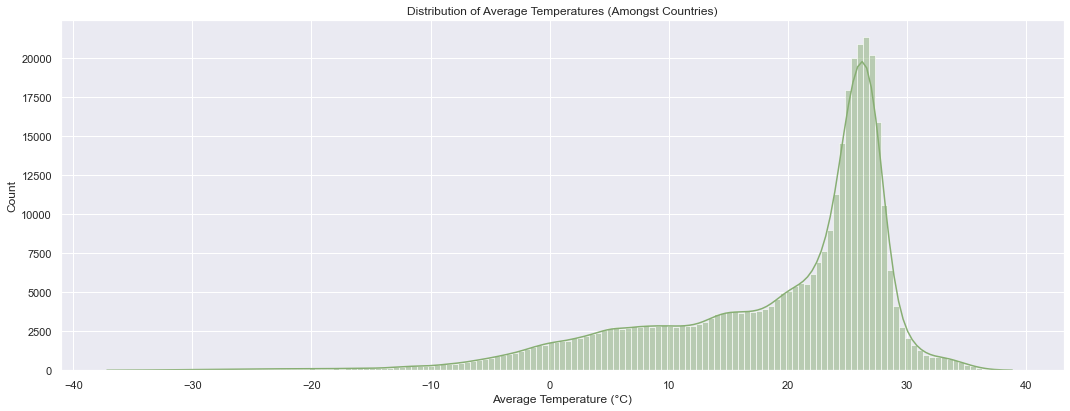

In [17]:
# distribution of ALL temperatures in filtered dataframe
sns.set(rc = {'figure.figsize':(16,6)})
ax = sns.histplot(country_filt_clean, x='AverageTemperature', binwidth=0.5, color='xkcd:sage', kde=True, legend=False)
ax.set_title('Distribution of Average Temperatures (Amongst Countries)')
ax.set_xlabel('Average Temperature (°C)')
ax.set_ylabel('Count')

For continuity, we will perform the same degree of "filtering" (i.e., from 1880 onward) with the `city` table.

In [18]:
city.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [19]:
city.shape[0]

8599212

In [20]:
# data types
city.dtypes

dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
City                                     object
Country                                  object
Latitude                                 object
Longitude                                object
dtype: object

In this table, we have the following columns:
* `dt` (datetime): date (YYYY-MM-DD), observations collected monthly from 1743-11-01 through 2013-09-01
* `AverageTemperature` (float): average temperature, recorded in degrees Celsius
* `AverageTemperatureUncertainty` (float): the 95% confidence interval around the average
* `City` (object, string): city name
* `Country` (object, string): country name
* `Latitude` (object, string): geo-coordinates, latitude (might need to be cleaned if used)
* `Longitude` (object, string): geo-coordinates, longitude (might need to be cleaned if used)

Similarly, now with over 8.5 million records, we will begin by cleaning the `city` table to see how many NaN values exist and where in the table they fall.

In [21]:
# checking for NaNs (count by column)
city.isna().sum()

dt                                    0
AverageTemperature               364130
AverageTemperatureUncertainty    364130
City                                  0
Country                               0
Latitude                              0
Longitude                             0
dtype: int64

In [22]:
# filtered by date (1880 onwards)
city_filt=city[(city['dt']>'1879-12-31')]
city_filt.shape[0]

5633253

In [23]:
city_filt.isna().sum()

dt                                   0
AverageTemperature               10780
AverageTemperatureUncertainty    10780
City                                 0
Country                              0
Latitude                             0
Longitude                            0
dtype: int64

After filtering by date, we now have 10,780 missing temperature records out of 5,633,253 in total (again, < 1%).

Again, now we can more confidently drop the NaN values that remain.

In [24]:
# drop NaNs inplace
city_filt.dropna(how='any',axis=0, inplace=True)

# confirm
city_filt.isna().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
dtype: int64

In [25]:
# the head of the working table
city_filt.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
1634,1880-01-01,-0.356,1.029,Århus,Denmark,57.05N,10.33E
1635,1880-02-01,1.503,0.290,Århus,Denmark,57.05N,10.33E
1636,1880-03-01,2.730,0.565,Århus,Denmark,57.05N,10.33E
1637,1880-04-01,6.505,0.411,Århus,Denmark,57.05N,10.33E
1638,1880-05-01,10.334,0.632,Århus,Denmark,57.05N,10.33E


We will now look at the countries that are represented in the `city` table.

In [26]:
# unique countries in dataset, sorted
unique_countries = pd.unique(city_filt['Country'])
unique_countries.sort()
print(unique_countries)

['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia'
 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh'
 'Belarus' 'Belgium' 'Benin' 'Bolivia' 'Bosnia And Herzegovina' 'Botswana'
 'Brazil' 'Bulgaria' 'Burkina Faso' 'Burma' 'Burundi' 'Cambodia'
 'Cameroon' 'Canada' 'Central African Republic' 'Chad' 'Chile' 'China'
 'Colombia' 'Congo' 'Congo (Democratic Republic Of The)' 'Costa Rica'
 'Croatia' 'Cuba' 'Cyprus' 'Czech Republic' "Côte D'Ivoire" 'Denmark'
 'Djibouti' 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador'
 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Ethiopia' 'Finland' 'France'
 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece' 'Guatemala'
 'Guinea' 'Guinea Bissau' 'Guyana' 'Haiti' 'Honduras' 'Hong Kong'
 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq' 'Ireland' 'Israel'
 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan' 'Kenya' 'Laos' 'Latvia'
 'Lebanon' 'Lesotho' 'Liberia' 'Libya' 'Lithuania' 'Macedonia'
 'Madagascar' 'Malawi' 'Malaysia' '

We don't seem to have the same problem with naming of countries in the `city` table as we did with the `country` table, which is great.

In [ ]:
#remaining records
print(f"In the 'AvgTempsbyCity' table, there are {city_filt.shape[0]} records amongst {city_filt['City'].nunique()} unique cities across {city_filt['Country'].nunique()} unique countries.")

In [ ]:
# identifying each unique city by its hemispheres (via lat/long)
city_filt['cardinal_NS'] = city_filt['Latitude'].str[-1:]
city_filt['cardinal_WE'] = city_filt['Longitude'].str[-1:]
city_filt['hemisphere'] = city_filt['cardinal_NS'] + city_filt['cardinal_WE']
city_filt.head()

[Back to TOC](#TOC)

**** 
<a id='EDA'></a>
### 3. [Exploratory Data Analysis (EDA)](#EDA)

Now that we have cleaned up and filtered both tables, we will look at the extremes of temperature records, in addition to the spread of average temperatures (across all years) across the globe.

In [ ]:
country_filt_clean.describe().T

With the quick summary above, we can see that, within the truncated (123-year) dataset, we have:
* 369,559 records in total,
* a minimum average temperature of -37.177°C 🥶,
* a maximum average temperature of 38.842°C 🥵,
* a resulting range of nearly 80°C (76.019°C, exactly) across all countries.

Now, our breakdown by hemisphere...

In [ ]:
hemi_df = city_filt.groupby('hemisphere')
hemi_df = hemi_df.agg({'Country': 'nunique'})
hemi_df = hemi_df.reset_index()

sns.set(rc = {'figure.figsize':(16,6)})
ax = sns.barplot(data=hemi_df, x='hemisphere', y='Country', palette='gist_earth_r')
ax.set_title('Count of Unique Countries by Hemisphere')
ax.set_xlabel('Hemisphere')
ax.set_ylabel('Country Count')

# label each bar in barplot
for p in ax.patches:
 height = p.get_height() # get the height of each bar
 # adding text to each bar
 ax.text(x = p.get_x()+(p.get_width()/2), # x-coordinate position of data label, padded to be in the middle of the bar
 y = height+1, # y-coordinate position of data label, padded 100 above bar
 s = '{:.0f}'.format(height), # data label, formatted to ignore decimals
 ha = 'center') # sets horizontal alignment (ha) to center

This breakdown is important to keep in mind if, for example, considering which area of the world is warmest/warming the fastest; the count of cities in the NE quadrant of Earth vastly outnumber those in all others (especially SW). A weighted average would be important to implement in such exploration.

In [ ]:
# series.boxplot('AverageTemperature', by = 'hemisphere', figsize=(16, 8), color='xkcd:forest green', grid=True)
sns.set(rc = {'figure.figsize':(16,6)})
ax = sns.boxplot(x='hemisphere', y='AverageTemperature', data=city_filt, color='xkcd:sage')
ax.set_title('Average Temperature by Hemisphere Boxplot')
ax.set_xlabel('Hemisphere')
ax.set_ylabel('Average Temperature')

Again, we can see that there are not only far more cities included in the dataset from the NE quadrant of the Earth, but that this area also has the greatest range in `AverageTemperature` (as denoted by the spread of whiskers). The region with the smallest range in temperatures is the SE. This is to be expected: the more values within a given group, the more likely there is to be greater variance across a singular quantitative measurement.

In [ ]:
# sns.displot(country_filt, x='AverageTemperature', binwidth=0.5)

sns.set(rc = {'figure.figsize':(16,6)})
ax = sns.histplot(city_filt, x='AverageTemperature', binwidth=1, color='xkcd:sage', hue='hemisphere', palette='gist_earth_r', alpha=0.4, kde=True, legend=True)
ax.set_title('Distribution of Average Temperatures (Cities by Hemisphere)')
ax.set_xlabel('Average Temperature (°C)')
ax.set_ylabel('Count')

[Back to TOC](#TOC)

<a id='Extremes'></a>
#### [Warmest & coldest countries/cities](#Extremes)

In [ ]:
# top 10 warmest temperatures (no aggregation)
country_filt_clean.nlargest(10,'AverageTemperature')

In [ ]:
# top 10 coldest temperatures (no aggregation)
country_filt_clean.nsmallest(10,'AverageTemperature')

From the two above outputs, we can see that the 10 warmest and coldest temperatures recorded belong to **Kuwait** and **Greenland**, respectively.

In fact, upon deeper digging, Kuwait still holds 18 of the top 20 warmest temperature recordings and Greenland holds more than *60* of the coldest average temperatures.

This is informative on its own but what if we wanted to look at the average temperature *across all years*?

In [ ]:
# warmest 5 countries by average average temperature
warmest_countries = country_filt_clean.groupby(['Country'])['AverageTemperature'].mean().sort_values(ascending=False).to_frame()
warmest_countries.head()

In [ ]:
# coldest 5 countries by average average temperature
coldest_countries = country_filt_clean.groupby(['Country'])['AverageTemperature'].mean().sort_values(ascending=True).to_frame()
coldest_countries.head()

What's going on here?

The coldest country is [significantly] Greenland. Conversely, Kuwait holds several of the warmest temperatures recorded but isn't on the "top 5 warmest countries on average" list.

Let's check to see all of Kuwait's records.

In [ ]:
# looking at distribution of temperatures in Kuwait
kuwait=country_filt_clean[(country_filt_clean['Country']=='Kuwait')]
sns.histplot(data=kuwait, x='AverageTemperature', stat='count', binwidth=1, color='xkcd:sage', kde=True).set_title('Distribution of Average Temperatures in Kuwait')
# to equally compare with Djibouti, set ranges on x- and y-axis
plt.xlim(0, 40)
plt.ylim(0, 200)

In [ ]:
# looking at distribution of temperatures in Djibouti
djibouti=country_filt_clean[(country_filt_clean['Country']=='Djibouti')]
sns.histplot(data=djibouti, x='AverageTemperature', stat='count', binwidth=1, color='xkcd:sage', kde=True).set_title('Distribution of Average Temperatures in Djibouti')
# to equally compare with Kuwait, set ranges on x- and y-axis
plt.xlim(0, 40)
plt.ylim(0, 200)

Looking at the two histograms above, we can see why Djibouti takes the crown as the warmest country *on average*: most of its average temperature records are concentrated within the 25-35°C range, whereas Kuwait has a much broader range of average temperatures. Specifically for Kuwait's distribution, the local peaks around 14°C and 20/21°C surely influence the overall average.

With that, we are able to concretely answer our first pair of questions. On average,
* the **warmest country** is **Djibouti** 🇩🇯, and
* the **coldest country** [by far] is **Greenland** 🇬🇱

In [ ]:
# average temperature for each country
countries=np.unique(country_filt_clean['Country'])
mean_temp=[]
for country in countries:
    mean_temp.append(country_filt_clean[country_filt_clean['Country']==country]['AverageTemperature'].mean())


data=[dict(
        type='choropleth',
        locations=countries,
        z=mean_temp,
        locationmode='country names',
        text=countries,
        marker=dict(
            line=dict(color='rgb(0,0,0)', width=1)),
            colorbar=dict(autotick=True, tickprefix='', 
            title='Average Temperature, °C')
            )
       ]

layout=dict(
    title='Average Land Temperature by Country',
    geo=dict(
        showframe=False,
        showocean=True,
        oceancolor='rgb(200,250,240)',
        projection=dict(
        type='orthographic',
            rotation=dict(
                    lon=60,
                    lat=10),
        ),
        lonaxis=dict(
                showgrid=True,
                gridcolor='rgb(102, 102, 102)'
            ),
        lataxis=dict(
                showgrid=True,
                gridcolor='rgb(102, 102, 102)'
                )
            ),
        )

fig=dict(data=data, layout=layout, figsize=(16, 16))
py.iplot(fig, validate=False, filename='worldmap')

In [ ]:
# here's an excessively long horizontal bar plot of average temperatures for ALL countries
mean_temp_bar, countries_bar=(list(x) for x in zip(*sorted(zip(mean_temp, countries), reverse=True)))
sns.set(font_scale=0.9) 
f,ax=plt.subplots(figsize=(18, 50))
colors_cw=sns.color_palette('coolwarm', len(countries))
sns.barplot(np.round(mean_temp_bar, decimals=2), countries_bar, palette=colors_cw[::-1])
ax.bar_label(ax.containers[0])
text=ax.set(xlabel='Average Temperature (°C)', title='Average Land Temperature (1880-2013)')

#### Exploring the "City" Table

In [ ]:
city_filt.describe().T

Once again, the quick summary above (and from cleaning earlier), we can see that, within the truncated (123-year) dataset, we have:
* 5,622,473 records in total,
* 3,448 unique cities.
* 159 countries,
* a minimum average temperature of -42.704°C 🥶🥶,
* a maximum average temperature of 39.156°C 🥵🥵,
* a resulting range of *more than* 80°C (81.86°C, exactly) across all cities.

Again, we will explore to see in which cities in the world these extreme temperatures were recorded.

In [ ]:
# top 5 warmest city temperatures (no aggregation)
city_filt.nlargest(10,'AverageTemperature')

In [ ]:
# top 10 coldest temperatures (no aggregation)
city_filt.nsmallest(10,'AverageTemperature')

Noticings from the above two outputs: 
* 39 of 40 warmest temperatures are recorded in **Iran**
    * though Ahvaz and Masjed E Soleyman have the same readings, they are, in fact, distinct cities. Perhaps the exact locations of temperature recording are too close but, for the sake of inclusivity, we will consider both.
* **Russia** has 60+ of coldest temperatures
    * Norilsk seems to be, consistently, the coldest (Kyzyl close second)
    
**\*Note**: there appear to be no cities from Greenland included in the `city` table. As a result, we can expect a *different* country to receive the torch in recognition of "coldest" (i.e., other than Greenland).

In [ ]:
# warmest 5 cities by average average temperature
warmest_cities = city_filt.groupby(['City'])['AverageTemperature'].mean().sort_values(ascending=False).to_frame()
warmest_cities.head()

Jibuti (Arabic for "Djibouti [City]") is the capital of Djibouti, the country. With Djibouti being the warmest country, on average across 1880 through 2013, perhaps this isn't too surprising that its capital—and largest city—is the warmest.

*Very* close contenders (within 0.05°C): Khartoum, Sudan; Umm Durman, Sudan; and Niamey, Niger.

In [ ]:
# coldest 5 cities by average average temperature
coldest_cities = city_filt.groupby(['City'])['AverageTemperature'].mean().sort_values(ascending=True).to_frame()
coldest_cities.head()

The top 5 coldest cities, on average, are all in Russia.

With this, we are able to concretely answer our second pair of questions. On average,
* the **warmest city** is **Jibuti, Djibouti** 🇩🇯, and
* the **coldest city** [by a significant margin] is **Norilsk, Russia** 🇷🇺

[Back to TOC](#TOC)

<a id='Trending'></a>
#### [Average Global Temperature Over Time](#Trending)

We will now look at the average temperature across all countries over time for the entire span of our time series. To compare and contrast, we will do the same with our cities and see if the two trends are significantly different.

In [ ]:
# average average country temperature over time (monthly)
month_countries=country_filt_clean.groupby(pd.Grouper(key='dt', freq="1M")).mean()
f,ax=plt.subplots(figsize=(18, 8))
sns.lineplot(data=month_countries, x='dt', y='AverageTemperature', color='xkcd:sage')
text=ax.set(xlabel='Time (monthly)', ylabel='Average Temperature (°C)', title='Average Monthly Global (COUNTRY) Temperature (1880-2013)')

Although we can see an upward trend, maybe monthly was too dense. Let's try annually.

In [ ]:
# average average country temperature over time (annual)
annual_countries=country_filt_clean.groupby(pd.Grouper(key='dt', freq="1Y")).mean()
f,ax=plt.subplots(figsize=(18, 8))
sns.lineplot(data=annual_countries, x='dt', y='AverageTemperature', color='xkcd:sage')
text=ax.set(xlabel='Time (annnual)', ylabel='Average Temperature (°C)', title='Average Annual Global (COUNTRY) Temperature (1880-2013)')

Now, we can clearly see a general trend of increasing global temperatures over time.

In [ ]:
# average average city temperature over time (monthly)
month_cities=city_filt.groupby(pd.Grouper(key='dt', freq="1M")).mean()
f,ax=plt.subplots(figsize=(18, 8))
sns.lineplot(data=month_cities, x='dt', y='AverageTemperature', color='xkcd:sage')
text=ax.set(xlabel='Time (monthly)', ylabel='Average Temperature (°C)', title='Average Monthly Global (CITY) Temperature (1880-2013)')

Once again, maybe a monthly basis is too dense to look at general trends. Instead, we will look at annual numbers.

In [ ]:
# average average city temperature over time (annual)
annual_cities=city_filt.groupby(pd.Grouper(key='dt', freq="1Y")).mean()
f,ax=plt.subplots(figsize=(18, 8))
sns.lineplot(data=annual_cities, x='dt', y='AverageTemperature', color='xkcd:sage')
text=ax.set(xlabel='Time (annnual)', ylabel='Average Temperature (°C)', title='Average Annual Global (CITY) Temperature (1880-2013)')

Since the geographical spread—and, as a result, diversity—is greater within the `city` table, we will use the trends found in the corresponding annual average plot to observe the average global temperature over time. By adding a trendline, we can see growth trend from 1880 through 2013.

[Back to TOC](#TOC)

**** 
<a id='Answers'></a>
### 4. [Answering Questions](#Answers)

<a id='Fastest'></a>
#### [Fastest-Warming Countries & Cities and Temperature Ranges](#Fastest)

As defined earlier, "fastest-warming*" will be measured by the rolling 10-year average increase in average temperature change. For the sake of recency, the rolling average will be calculated over the 5 and 10 most recent full years; since the data set ends of 2013, we will look at the rolling averages from the past 50 years (from 1938 onward).

We will first filter our dataframe and then add columns for year-over-year growth as a percentage, in addition to rolling 10-year average of these year-over-year growth values.

In [ ]:
# filter 1938 through 2013 (about 50 years)
fast_warm_country = country_filt_clean[(country_filt_clean['dt']>='1938-01-01')]
fast_warm_country.head()

In [ ]:
# group by country and by year
# return min, max, and avg temps
fast_warm_country = fast_warm_country.groupby(['Country', fast_warm_country.dt.dt.year]).agg({'AverageTemperature': ['min', 'max','mean']})
fast_warm_country.columns = ['min_temp', 'max_temp', 'avg_temp']

fast_warm_country = fast_warm_country.reset_index()

fast_warm_country.head()

In [ ]:
fast_warm_country['temp_range']=fast_warm_country['max_temp'] - fast_warm_country['min_temp']

fast_warm_country.head()

In [ ]:
# adding pct_change, 5-yr, and 10-yr columns
fast_warm_country['pct_change']=(fast_warm_country['avg_temp'].diff() / fast_warm_country['avg_temp'].abs().shift())*100
fast_warm_country['five_yr_avg_pct_change']=fast_warm_country['pct_change'].rolling(5).mean()
fast_warm_country['ten_yr_avg_pct_change']=fast_warm_country['pct_change'].rolling(10).mean()

fast_warm_country.head(20)

In [ ]:
# top 20 five_yr_avg (by country)
fast_warm_country.nlargest(20,'five_yr_avg_pct_change')

Finland in the 50s/60s!

With such **massive** `five_yr_avg_pct_change` values, let's investigate the temperatures recorded in Finland over this time.

In [ ]:
finland_warming = fast_warm_country.loc[(fast_warm_country['Country'] == 'Finland') & (fast_warm_country['dt'] > 1950)]
finland_warming.head(20)

In [ ]:
# Finland average temperature over time (annual)
finland_warming = fast_warm_country.loc[(fast_warm_country['Country'] == 'Finland') & (fast_warm_country['dt'] > 1900)]

f,ax=plt.subplots(figsize=(18, 8))
sns.lineplot(data=finland_warming, x='dt', y='avg_temp', color='xkcd:sage')
text=ax.set(xlabel='Time (annnual)', ylabel='Average Temperature (°C)', title='Average Annual Temperature in Finland (1900-2013)')

The `pct_change` in `avg_temp` in Finland from 1957 to 1958 was **more than 13,000%**! Of course, looking at the true values of `avg_temp`, we see a change that would likely be imperceptible to the vast majority of people (–0.015917 up to 2.058167) but the *rate of change* is still not the be taken likely.

In [ ]:
# top 20 ten_yr_avg (by country)
fast_warm_country.nlargest(20,'ten_yr_avg_pct_change')

This `pct_change` has a **huge** impact on subsequent five- and ten-year rolling averages.

A quick look at temperature ranges (since extreme temperatures are related to extreme weather events and climate change, as a whole).

In [ ]:
# top 5 temp_range (by country)
fast_warm_country.nlargest(5,'temp_range')

In [ ]:
# smallest 5 temp_range (by country)
fast_warm_country.nsmallest(5,'temp_range')

From the above, we can conclude:
* historically, **Finland** was the fastest-warming country in the middle of the 20th century
* *more recently*, **Mongolia** has demonstrated relatively rapid warming into the beginning of 21st century
* the countries with the greatest range in average temperatures were **Kazakhstan**, **Russia**, and **Mongolia**
* the countries with the least range in average temperatures were **Federated States Of Micronesia**, **Indonesia**, and **American Samoa** (all island nations close to the equator)

With this, we can observe that **Finland** 🇫🇮 and **Mongolia** 🇲🇳 are the fastest-warming countries (historically and more recently, respectively).

The country with the greatest `temp_range` was **Kazakhstan** 🇰🇿 in 1969 and the country with the least `temp_range` was **[The] Federated States of Micronesia** 🇫🇲 in 1994.

Now, using a similar approach with the `city` table, we will find the fastest-warming city.

In [ ]:
# filter 1938 through 2013 (about 50 years)
fast_warm_city = city_filt[(city_filt['dt']>='1938-01-01')]
fast_warm_city.head()

In [ ]:
# group by city and by year
# return min, max, and avg temps
fast_warm_city = fast_warm_city.groupby(['City', fast_warm_city.dt.dt.year]).agg({'AverageTemperature': ['min', 'max','mean']})
fast_warm_city.columns = ['min_temp', 'max_temp', 'avg_temp']

fast_warm_city = fast_warm_city.reset_index()

fast_warm_city.head()

In [ ]:
fast_warm_city['temp_range']=fast_warm_city['max_temp'] - fast_warm_city['min_temp']

fast_warm_city.head()

In [ ]:
# adding pct_change, 5-yr, and 10-yr columns
fast_warm_city['pct_change']=(fast_warm_city['avg_temp'].diff() / fast_warm_city['avg_temp'].abs().shift())*100
fast_warm_city['five_yr_avg_pct_change']=fast_warm_city['pct_change'].rolling(5).mean()
fast_warm_city['ten_yr_avg_pct_change']=fast_warm_city['pct_change'].rolling(10).mean()

fast_warm_city.head()

In [ ]:
# top 20 five_yr_avg (by city)
fast_warm_city.nlargest(20,'five_yr_avg_pct_change')

Contenders for fastest-warming city include **Nizhniy Novgorod** (Russia) and **Angeles** (Philippines). We will now look at the 10-year rolling average to decide.

In [ ]:
# top 20 ten_yr_avg (by city)
fast_warm_city.nlargest(20,'ten_yr_avg_pct_change')

Once again, a look at temperature ranges by city.

In [ ]:
# top 5 temp_range (by city)
fast_warm_city.nlargest(5,'temp_range')

In [ ]:
# bottom 5 temp_range (by city)
fast_warm_city.nsmallest(5,'temp_range')

Again, we can conclude:
* historically, **Nizhniy Novgorod, [Western] Russia** was the fastest-warming city just before the middle of the 20th century
* *more recently*, **Abakan, [Southern] Russia** has demonstrated relatively rapid warming leading into the beginning of 21st century
* the city with the greatest range in average temperature was **Norilsk, Russia** in 1979
* the cities with the least range in average temperature were **Balikpapan**, **Loa Janan**, and **Samarinda** in 2007 (all distinct cities within ~110 km of one another in Indonesia)

We observe that **Nizhniy Novgorod** and **Abakan** are the fastest-warming cities (historically and more recently, respectively), both of which are in Russia 🇷🇺.

The city with the greatest range in average temperature was **Norilsk, Russia** 🇷🇺 in 1979 and those with the least range in average temperature were **Balikpapan**, **Loa Janan**, and **Samarinda** 🇮🇩 in 2007.

[Back to TOC](#TOC)

**** 
<a id='Conclusion'></a>
### 5. [Conclusions, Recommendations, and Areas for Further Exploration](#Conclusion)

#### Conclusions
In summary, we determined that, from 1880 to 2013,
* on average, the **coldest country** was **Greenland**
* on average, the **warmest country** was **Djibouti**
* on average, the **coldest city** was **Norilsk, Russia**
* on average, the **warmest city** was **Jibuti, Djibouti**
* the country with the greatest range in average temperatures was **Kazakhstan**
* the cities with the greatest range in average temperatures were **Balikpapan**, **Loa Janan**, and **Samarinda** (all Indonesia)
* the **countries** that have the **greatest rate of warming** were **Finland and Mongolia** (historically and recently, respectively)
* the **cities** that have the **greatest rate of warming** were **Nizhniy Novgorod and Abakan** (historically and recently, respectively)

#### Hypotheses, revisited
Checking in with the aforementioned hypotheses:
* the coldest countries and cities will be situated closer to the North/South poles --> **SUPPORTED**
* the warmest countries and cities will be situated closer to the equator --> **SUPPORTED**
* the countries and cities with the greatest rate of warming will be closer to the poles --> **PARTIALLY SUPPORTED for country; SUPPORTED for city**

#### Recommendations
The results of this analysis would [hopefully] be of interest to most global citizens. While these findings may be concerning—especially for residents of the countries and/or cities listed above—they do have the opportunity to be motivating and empowering, too.

Additionally, it is important to remember that the areas of Earth that experience the most extreme temperatures are not necessarily those contributing heavily to the changing climate. With wind and ocean currents constantly being influenced by the motion of our planet, often times heavy pollutants, for example, can travel large distances and have an effect on communities and ecosystems thousands of kilometres away.

Ultimately, the results from this analysis could serve as data-driven reasoning to work to mitigate our anthropogenic contributions to climate change. Of course, climate change has taken place on Earth from time immemorial, as shown in the geological record; rather, it is the rapid rate and the magnitude of climate change occurring now that is of great concern worldwide.

That said, it is important to note that the of limitations in the dataset suggest these findings should not be taken as gospel but, instead, a *soft* warning or realization (from an admittedly-amateur climate scientist).
* **Temporal limitations** in both directions:
    * the uncertainty associated with early-recorded temperatures (e.g., 1743 through 1900) is much greater than more recent dates, making these records potentially less reliable
    * the most recent month of recorded temperatures across both tables is *August of 2013*, nearly 10 years ago, at time of analysis
* **Collection methods**:
    * early data was collected by technicians using mercury thermometers, where any variation in the visit time impacted measurements
    * in the 1940s, the construction of airports caused many weather stations to be moved
    * in the 1980s, there was a transition to electronic thermometers that are said to have a cooling bias
* **Monthly aggregations**: each record is dated as the first of every month, suggesting averaging over each day of the month
* **Locations**: with 3,448 unique cities across 159 countries, there are clearly many areas of the world—even areas of each country—that are not included that could give a much fuller picture of temperature changes


#### Areas for Further Exploration
Given the limitaitons listed above, this analysis and accompanying dataset can still be used for diagnostic purposes despite the raw dataset containing various artifacts that may make it an unreliable recorder of Earth's climate history/future. That said, there are still many directions in which to proceed:
* **Forecasting**: given the [personal] limitations of time and the existing length of the analysis, forecasting of temperatures for a given city was not included. This will be added after-the-fact to demonstrate seasonal modelling.
* **Improved Geo-Coordinates**: while it was not the main focus of this analysis, it would be informative to join the existing tables with those that include more accurate latitude and longitude measurements (as opposed to rounded off to two decimal places). With this information, a more detailed look at temperatures and/or temperature changes by location could provide deeper insights.
* **Other Geographical Information**: measurements such as altitude, humidity, proximity to water/length of coastline, or even population density would be interesting to explore as other variables that may or may not have some correlation with temperatures changes.

[Back to TOC](#TOC)

**** 


\~*fin*\~

**** 